# Object Localization 

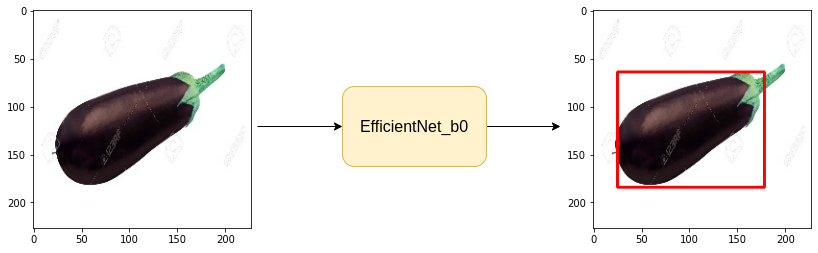

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-hdegks44
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-hdegks44
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=c4390fd5c8b82dd48bee9d75eb0e5ccabece5993b60f162363530ed614659743
  Stored in directory: /tmp/pip-ephem-wheel-cache-1k2trmf2/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 36.84 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4 #number of co-ordinates for bounding box

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

Text(0.5, 1.0, 'eggplant')

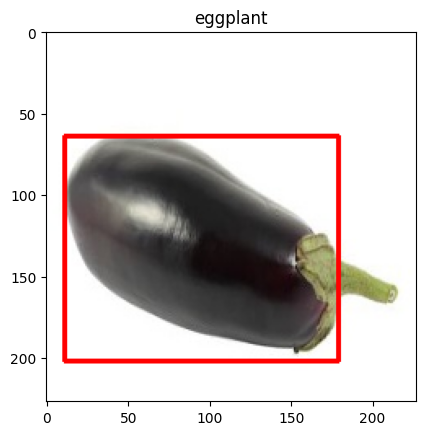

In [ ]:
row = df.iloc[10]
img_path = row.img_path
title = row.label
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
img = cv2.imread(DATA_DIR + img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255., 0., 0.), 2)
plt.imshow(bnd_box_img)
plt.title(title)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)
print(len(train_df), len(valid_df))

148 38


# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class ObjLocDataset(Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image=img, bboxes = bbox, class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total examples in the trainset:{len(trainset)}")
print(f"Total examples in the validset:{len(validset)}")

Total examples in the trainset:148
Total examples in the validset:38


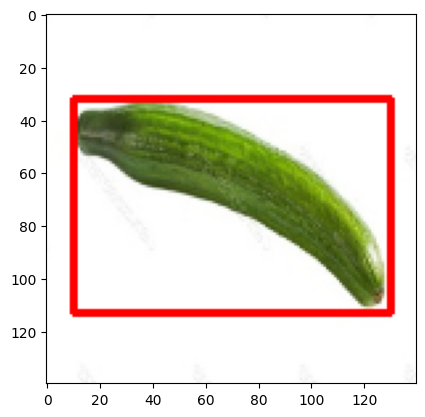

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
images, bboxes = next(iter(trainloader))

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes !=None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [ ]:
model = ObjLocModel().to(DEVICE)

In [ ]:
rand_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(rand_img)

tensor([[-0.9453,  0.6385, -1.4067,  0.7440]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.
  model.train()

  for images, gt_bboxes in tqdm(dataloader):
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    
    bboxes, loss = model(images, gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.
  model.eval()

  with torch.inference_mode():
    for images, gt_bboxes in tqdm(dataloader):
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    print('WEIGHTS ARE SAVED')
    best_valid_loss = valid_loss

  print(f"Epochs : {i+1} | train loss : {train_loss} | valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epochs : 1 | train loss : 49.43703842163086 | valid loss: 113.60222625732422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epochs : 2 | train loss : 50.67728805541992 | valid loss: 60.61949793497721


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epochs : 3 | train loss : 49.36637496948242 | valid loss: 57.67832946777344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epochs : 4 | train loss : 42.58354187011719 | valid loss: 43.60893567403158


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 5 | train loss : 54.175323486328125 | valid loss: 67.24281946818034


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 6 | train loss : 49.59625244140625 | valid loss: 72.0918197631836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 7 | train loss : 46.1526985168457 | valid loss: 63.837774912516274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 8 | train loss : 41.090721130371094 | valid loss: 53.4452273050944


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 9 | train loss : 54.91877365112305 | valid loss: 57.79052861531576


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 10 | train loss : 41.0849494934082 | valid loss: 69.1707534790039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 11 | train loss : 50.96887969970703 | valid loss: 48.2290407816569


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 12 | train loss : 44.61924362182617 | valid loss: 62.41019821166992


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 13 | train loss : 36.881629943847656 | valid loss: 63.85784403483073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 14 | train loss : 31.601505279541016 | valid loss: 45.02960205078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 15 | train loss : 36.38581085205078 | valid loss: 72.73068491617839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 16 | train loss : 37.05126953125 | valid loss: 89.44970321655273


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 17 | train loss : 48.37534713745117 | valid loss: 74.79031880696614


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 18 | train loss : 41.4598503112793 | valid loss: 58.713677724202476


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 19 | train loss : 33.45017623901367 | valid loss: 75.21466700236003


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 20 | train loss : 44.606658935546875 | valid loss: 47.775960286458336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 21 | train loss : 33.969932556152344 | valid loss: 54.27244758605957


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 22 | train loss : 36.86552810668945 | valid loss: 56.40629196166992


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 23 | train loss : 39.13300323486328 | valid loss: 49.667311350504555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epochs : 24 | train loss : 42.76130294799805 | valid loss: 42.29061317443848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 25 | train loss : 42.38204574584961 | valid loss: 78.14672088623047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 26 | train loss : 30.8602352142334 | valid loss: 55.715867360432945


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 27 | train loss : 51.8546028137207 | valid loss: 43.43305905659994


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 28 | train loss : 32.69879150390625 | valid loss: 42.77170753479004


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 29 | train loss : 33.5098762512207 | valid loss: 49.971858978271484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 30 | train loss : 37.201107025146484 | valid loss: 56.54757181803385


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 31 | train loss : 28.44752311706543 | valid loss: 78.92932891845703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 32 | train loss : 26.761259078979492 | valid loss: 49.76583925882975


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 33 | train loss : 30.03786277770996 | valid loss: 43.68088022867838


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 34 | train loss : 50.06781005859375 | valid loss: 67.69338989257812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 35 | train loss : 38.8135871887207 | valid loss: 51.43264389038086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 36 | train loss : 29.55484962463379 | valid loss: 52.04267501831055


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 37 | train loss : 30.575101852416992 | valid loss: 59.64594523111979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 38 | train loss : 36.38480758666992 | valid loss: 48.26615651448568


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 39 | train loss : 31.943265914916992 | valid loss: 46.57339604695638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 40 | train loss : 32.98878479003906 | valid loss: 64.61317316691081


#Inference

In [ ]:
import utils

In [ ]:
#compare function implemented on utils module
def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)

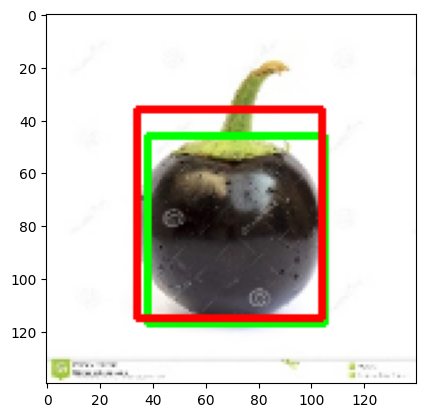

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.inference_mode():
  image, gt_bbox = validset[20]
  image = image.unsqueeze(0).to(DEVICE)
  out_box = model(image)

  utils.compare_plots(image, gt_bbox, out_box)